<h1 align="center">Fusion d'images IRM et MALDI</h1>

## Contexte

**Objectif** : identifier de nouvelles molécules liées au transfert d'eau dans le grain de blé.

**IRM** : image de la densité et de la mobilité de l'eau.
<img src="../Data/mri.png" width="200" />

**MALDI** : images de la répartition d'un grand nombre de molécules
<img src="../Data/maldi_cube.png" width="200" />

&rarr; Fusion d'images MALDI et IRM.

Chaîne de traitement :
<img src="../Data/workflow4.png" width="400" />


Nous nous intéressons ici uniquement au recalage et à l'analyse statistique entre les deux images.

## Recalage 
Estimation de la **transformation géométrique** permettant la superposition d'une image **mobile** sur une image **fixe**.

<img src="../Data/anim.gif" />

Les méthodes de recalage impliquent trois composantes :
  *  La **transformation géométrique** : rigide, affine, déformable
  *  La **métrique** : mesure la similarité, en termes de distance, entre l'image fixe et mobile, en termes d'intensité ou de géométrie
  *  L'**optimisation** : méthode pour la détermination du minimum de la métrique
  
Nous allons utiliser la bibliothèque Python [**SimpleITK**](https://simpleitk.readthedocs.io/en/master/Documentation/docs/source/installation.html). SimpleITK fournit une interface simplifiée pour l'accès aux fonctions d'ITK. 

Voici le diagramme présentant l'organisation des différentes composantes pour le recalage :

<img src="ITKv4RegistrationComponentsDiagram.svg" style="width:700px"/><br><br>

Voici différents exemples pour le choix des composantes :

### Transformations
SimpleITK supporte différents types de transformations géométriques pour le recalage :
  * <a href="http://www.itk.org/Doxygen/html/classitk_1_1TranslationTransform.html">TranslationTransform</a> : 2D or 3D, translation
  * <a href="http://www.itk.org/Doxygen/html/classitk_1_1Euler2DTransform.html">Euler2DTransform</a> : 2D, transformation rigide avec rotation sous la forme d'angle d'Euler
  * <a href="http://www.itk.org/Doxygen/html/classitk_1_1Euler3DTransform.html">Euler3DTransform</a> : 3D, transformation rigide avec rotations sous la forme d'angles d'Euler
  * <a href="http://www.itk.org/Doxygen/html/classitk_1_1Similarity2DTransform.html">Similarity2DTransform</a> : 2D, composition d'homothétie et d'une transformation rigide dont la rotation est sous la forme d'un angle d'Euler
  * <a href="http://www.itk.org/Doxygen/html/classitk_1_1ScaleTransform.html">ScaleTransform</a> : 2D ou 3D, homothétie
  * <a href="http://www.itk.org/Doxygen/html/classitk_1_1AffineTransform.html">AffineTransform</a> : 2D ou 3D, transformation affine
  * <a href="http://www.itk.org/Doxygen/html/classitk_1_1BSplineTransform.html">BSplineTransform</a> : 2D ou 3D, transformation non rigide représentée par une grille régulière de points de contrôle 
  * <a href="http://www.itk.org/Doxygen/html/classitk_1_1DisplacementFieldTransform.html">DisplacementFieldTransform</a> : 2D ou 3D, transformation non rigide représentée par une grille régulière de vecteurs
  * <a href="http://www.itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1Transform.html">Transform</a> : transformation générique


### Métriques

SimpleITK supporte différentes métriques via les fonctions SetMetricAsX() :

<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MeanSquaresImageToImageMetricv4.html">MeanSquares</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1DemonsImageToImageMetricv4.html">Demons</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1CorrelationImageToImageMetricv4.html">Correlation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ANTSNeighborhoodCorrelationImageToImageMetricv4.html">ANTSNeighborhoodCorrelation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1JointHistogramMutualInformationImageToImageMetricv4.html">JointHistogramMutualInformation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MattesMutualInformationImageToImageMetricv4.html">MattesMutualInformation</a>
  </li>
</ul>

### Méthodes d'optimisation

Différents types d'optimisation sont supportés, et spécifiés par les fonctions SetOptimizerAsX() :

<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ExhaustiveOptimizerv4.html">Exhaustive</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1AmoebaOptimizerv4.html">Nelder-Mead downhill simplex</a>, a.k.a. Amoeba.
  </li>
  <li>
   <a href="https://itk.org/Doxygen/html/classitk_1_1PowellOptimizerv4.html">Powell optimizer</a>.
  </li>
  <li>
   <a href="https://itk.org/Doxygen/html/classitk_1_1OnePlusOneEvolutionaryOptimizerv4.html">1+1 evolutionary optimizer</a>.
  </li>
  <li>
  Descente de gradient:
  <ul>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentOptimizerv4Template.html">GradientDescent</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentLineSearchOptimizerv4Template.html">GradientDescentLineSearch</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1RegularStepGradientDescentOptimizerv4.html">RegularStepGradientDescent</a>
    </li>
  </ul>
  </li>
  <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1ConjugateGradientLineSearchOptimizerv4Template.html">ConjugateGradientLineSearch</a> 
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1LBFGSBOptimizerv4.html">L-BFGS-B</a> (Limited memory Broyden, Fletcher, Goldfarb, Shannon-Bound Constrained) - supporte l'utilisation de contraintes simples ($l\leq x \leq u$)
  </li>
  <li>
  <a href="https://itk.org/Insight/Doxygen/html/classitk_1_1LBFGS2Optimizerv4.html">L-BFGS2</a> (Limited memory Broyden, Fletcher, Goldfarb, Shannon) 
  </li>
</ul>

## Fonctions utiles
Diverses fonctions utiles pour le chargement et la visualisation des images :

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt

import SimpleITK as sitk

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('Image fixe')
    plt.axis('off')

    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('Image mobile')
    plt.axis('off')

    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    fixed_u8 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    moving_u8 = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
    img = sitk.Compose(fixed_u8, moving_u8, fixed_u8//3.+moving_u8//1.5)
    plt.imshow(sitk.GetArrayFromImage(img));
    plt.axis('off')
    plt.show()

def display_current_image(registration_method, transform, fixed_image, moving_image):
    global metric_values, multires_iterations

    clear_output(wait=True)
    
    im = sitk.Resample(moving_image, fixed_image, transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    im_npa = sitk.GetArrayFromImage(im)
    fixed_npa = sitk.GetArrayFromImage(fixed_image)
    
    #Create a figure with two subplots and the specified size.
    plt.subplots(1,3,figsize=(15,5))

    # Draw the fixed image in the first subplot.
    plt.subplot(1,3,1)
    plt.imshow(fixed_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')

    # Draw the moving image in the second subplot.
    plt.subplot(1,3,2)
    plt.imshow(im_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.tight_layout()
    plt.show()
       
#    display_images(0, 0, sitk.GetArrayFromImage(fixed_image), sitk.GetArrayFromImage(im))
#    plot_values(registration_method)
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()

# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

## Chargement des données
Chargement des images fixe (IRM) et mobile (MALDI):

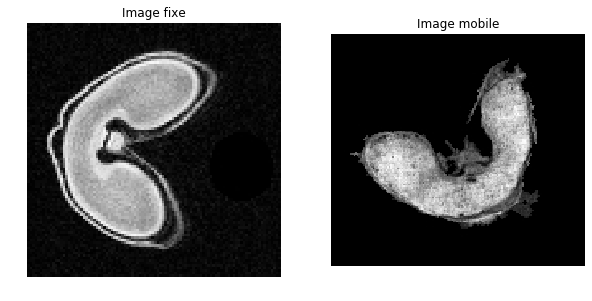

In [93]:
fixed_image =  sitk.ReadImage("../Data/mri.jpg",
sitk.sitkFloat32)

moving_image = sitk.ReadImage("../Data/maldi.jpg", sitk.sitkFloat32)

interact(display_images, fixed_image_z=0, moving_image_z=0, fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

## Recalage rigide

Pour ce recalage, nous utilisons :
- métrique : information mutuelle de Mattes, basée sur l'histogramme conjoint des intensités entre deux images
- transformation : transformation rigide => homothétie + translation + rotation
- optimisation : descente de gradient

La transformation est initialisée en alignant les centres des deux objets (cf. CenteredTransformInitializer)

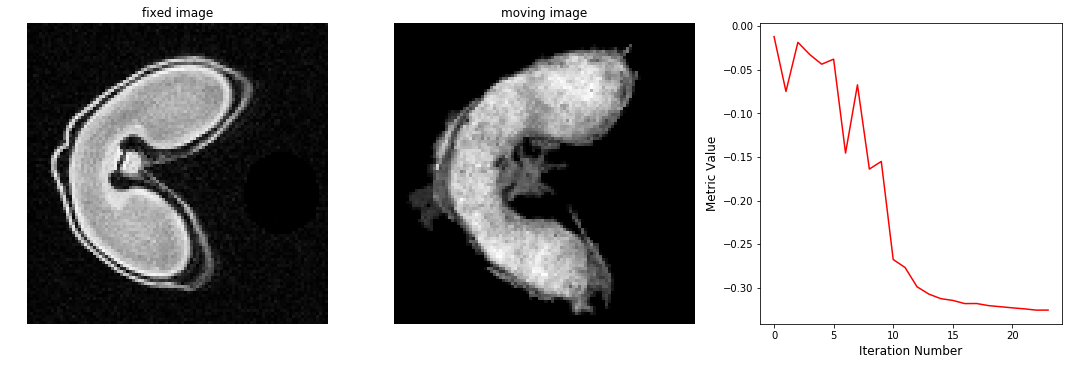

In [102]:
numberOfBins = 15
registration_method = sitk.ImageRegistrationMethod()

# Métrique
registration_method.SetMetricAsMattesMutualInformation(numberOfBins)

# Algorithme d'optimisation
registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                                             minStep=0.02,
                                                             numberOfIterations=100,
                                                             relaxationFactor=0.7, 
                                                             gradientMagnitudeTolerance = 1e-4,
                                                             maximumStepSizeInPhysicalUnits = 0.0) 
# Transformation
transform = sitk.CenteredTransformInitializer(fixed_image,
                                              moving_image,
                                              sitk.Similarity2DTransform(),
                                              sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(transform)

registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: display_current_image(registration_method, transform, fixed_image, moving_image))


outTx = registration_method.Execute(fixed_image, moving_image)

moving_resampled = sitk.Resample(moving_image, fixed_image, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

## Analyse du recalage

### Choix des paramètres
La valeur finale de la métrique ainsi que la raison de la terminaison de l'algorithme d'optimisation permettent d'ajuster les paramètres du recalage. Cela aide à identifier lorsque la terminaison de l'algorithme est trop rapide, à cause de :
* un trop faible nombre d'itérations (numberOfIterations)
* un changement trop faible dans la mesure de similarité (minStep)

In [97]:
print('Valeur finale de la métrique: {0}'.format(registration_method.GetMetricValue()))
print('Condition de terminaison de l\'algorithme d\'optimisation , {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Valeur finale de la métrique: -0.32710372112394165
Condition de terminaison de l'algorithme d'optimisation , RegularStepGradientDescentOptimizerv4: Step too small after 24 iterations. Current step (0.0193778) is less than minimum step (0.02).


### Analyse quantitative
On peut tout d'abord afficher la superposition des deux images :

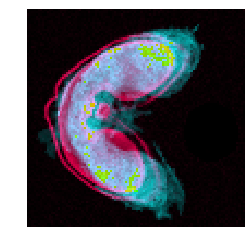

<function __main__.display_images_with_alpha(image_z, alpha, fixed, moving)>

In [109]:
interact(display_images_with_alpha, image_z=(0,1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

In [ ]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

If we are satisfied with the results, save them to file.